# Assigment 2: CAMSHIFT
## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

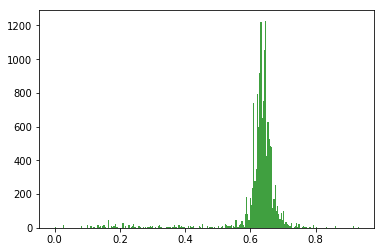

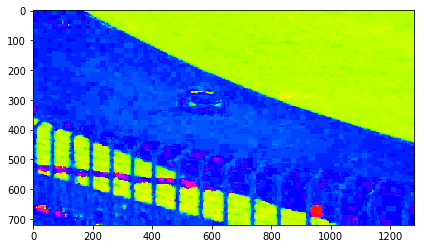

In [85]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')
import math
IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20

image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

# ...

def createColorHistogram(img, binCount = 256, out = plt):
    roi = color.rgb2hsv(img)
    #io.imshow(roi)    
    #initialize list for plotting
    pixel = []
    
    #search and count pixel hues
    for x in range(roi.shape[0]):
        for y in range(roi.shape[1]):
            hue = roi[x][y][0]
            pixel.append(hue)
            
    n, bins, patches = plt.hist(pixel, binCount,  facecolor='g', alpha=0.75) 
    plt.show() 
    
    # We'll color code by height, but you could use any scalar
    fracs = n / n.max()

    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        #thispatch.set_facecolor(color1)
        pass

    # We can also normalize our inputs by the total number of counts
    #axs[1].hist(x, bins=n_bins, density=True)
    
createColorHistogram(imageCar)

img_hsv = color.rgb2hsv(image)
img_hsv[:, :, 1] = 1
img_hsv[:, :, 2] = 1

img_rgb = color.hsv2rgb(img_hsv)
io.imshow(img_rgb)


* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
    
# histCar100 = createColorHistogram(imageCar, 100, ax1)
# histCar10 = createColorHistogram(imageCar, 10, ax1)


## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

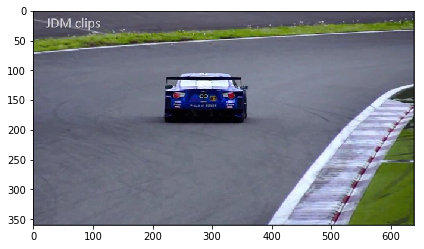

In [86]:
# Tip: in der Nacht sind alle Katzen grau ;)
# def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    #...
            
lastFrame = io.imread('images/racecar/151.jpeg')
io.imshow(lastFrame)
# histogramCar = createColorHistogram(imageCar, nbins, ax1)
# probDistr = createProbDistribution(lastFrame, histogramCar, nbins, MIN_SATURATION_CAR, MIN_VALUE_CAR)
# io.imshow(probDistr)

### ROI auf Bild anzeigen


In [ ]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

# showRoiFrame(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)